In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/thanjavur-dataset-new/updated_dataset .csv


# WITHOUT FEATURE SELECTION


🔹 PCA Components Retained: 7


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 34s 5ms/step - accuracy: 0.8167 - loss: 0.4087 - val_accuracy: 0.8440 - val_loss: 0.3529
Epoch 2/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8408 - loss: 0.3565 - val_accuracy: 0.8517 - val_loss: 0.3351
Epoch 3/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8456 - loss: 0.3465 - val_accuracy: 0.8566 - val_loss: 0.3273
Epoch 4/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8494 - loss: 0.3401 - val_accuracy: 0.8604 - val_loss: 0.3208
Epoch 5/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8529 - loss: 0.3324 - val_accuracy: 0.8615 - val_loss: 0.3188
Epoch 6/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8545 - loss: 0.3295 - val_accuracy: 0.8630 - val_loss: 0.3125
Epoch 7/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8550 - loss: 0.3266 - val_accuracy: 0.8642 - val_loss: 0.3091
Epoch 8/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8556 - loss: 0

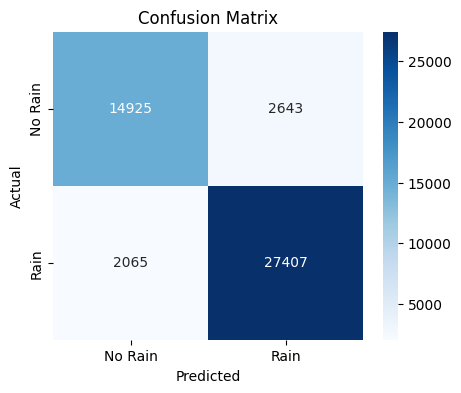

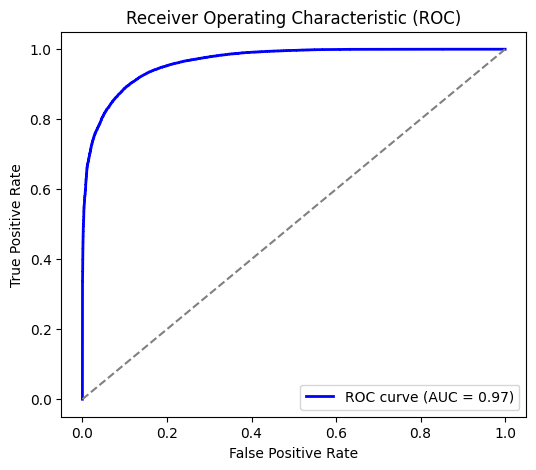


📊 Model Performance Metrics:
Accuracy: 0.8999
Precision: 0.9120
Recall: 0.9299
F1-Score: 0.9209
G-Mean: 0.8888


In [1]:
# ✅ Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc
)
from imblearn.metrics import geometric_mean_score

# ✅ Load dataset
df = pd.read_csv("/kaggle/input/thanjavur-dataset-new/updated_dataset .csv")  # Change to your dataset

# ✅ Remove Missing Values
df.dropna(inplace=True)

# ✅ Remove Outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# ✅ Define Features & Target
# 🔥 Removing highly correlated features (`T2MDEW`, `RainToday`)
X = df.drop(columns=["RainTomorrow", "T2MDEW", "RainToday"])
y = df["RainTomorrow"]

# ✅ Normalize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Apply Quantile Transformation
qt = QuantileTransformer(output_distribution="normal", random_state=42)
X_transformed = qt.fit_transform(X_scaled)

# ✅ Apply PCA (Keep 95% Variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_transformed)
print(f"\n🔹 PCA Components Retained: {pca.n_components_}")

# ✅ Apply Clustering (KMeans)
n_clusters = 3  # You can tune this
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# ✅ Add Cluster Labels to Data
X_final = np.hstack((X_pca, cluster_labels.reshape(-1, 1)))

# ✅ Reshape Data for LSTM (samples, timesteps, features)
X_reshaped = X_final.reshape((X_final.shape[0], 1, X_final.shape[1]))

# ✅ Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Define Early Stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# ✅ Define LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

# ✅ Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# ✅ Train Model with Early Stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# ✅ Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

# ✅ Print Performance Metrics
print("\n📊 Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"G-Mean: {g_mean:.4f}")


# WITH FEATURE SELECTION


🔥 Selected Features: ['T2M', 'T2M_MIN', 'RH2M', 'PRECTOTCORR', 'PS']

🔹 PCA Components Retained: 3
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


5880/5880 ━━━━━━━━━━━━━━━━━━━━ 31s 5ms/step - accuracy: 0.8036 - loss: 0.4391 - val_accuracy: 0.8162 - val_loss: 0.4046
Epoch 2/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8124 - loss: 0.4120 - val_accuracy: 0.8176 - val_loss: 0.4002
Epoch 3/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8141 - loss: 0.4096 - val_accuracy: 0.8187 - val_loss: 0.3988
Epoch 4/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8138 - loss: 0.4085 - val_accuracy: 0.8203 - val_loss: 0.3958
Epoch 5/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8146 - loss: 0.4047 - val_accuracy: 0.8197 - val_loss: 0.3955
Epoch 6/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8156 - loss: 0.4026 - val_accuracy: 0.8200 - val_loss: 0.3901
Epoch 7/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8163 - loss: 0.4001 - val_accuracy: 0.8207 - val_loss: 0.3862
Epoch 8/50
5880/5880 ━━━━━━━━━━━━━━━━━━━━ 30s 5ms/step - accuracy: 0.8163 - loss: 0.3935 - val

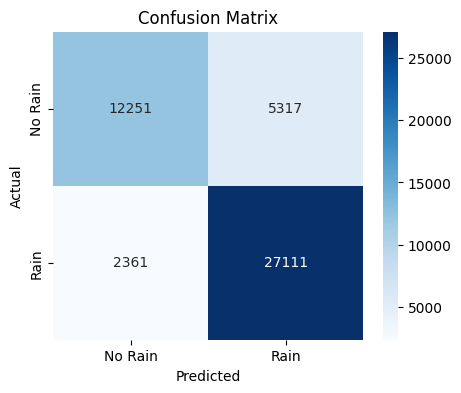

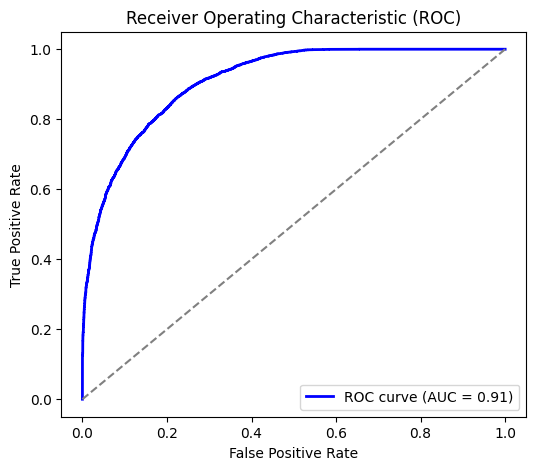


📊 Model Performance Metrics:
Accuracy: 0.8368
Precision: 0.8360
Recall: 0.9199
F1-Score: 0.8760
G-Mean: 0.8009


In [2]:
# ✅ Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, 
    confusion_matrix, roc_curve, auc
)
from imblearn.metrics import geometric_mean_score

# ✅ Load dataset
df = pd.read_csv("/kaggle/input/thanjavur-dataset-new/updated_dataset .csv")  # Change to your dataset

# ✅ Remove Missing Values
df.dropna(inplace=True)

# ✅ Remove Outliers using IQR
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
df = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]

# ✅ Define Features & Target
# 🔥 Removing highly correlated features (`T2MDEW`, `RainToday`)
X = df.drop(columns=["RainTomorrow", "T2MDEW", "RainToday"])
y = df["RainTomorrow"]

# ✅ Normalize Data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ✅ Apply Quantile Transformation
qt = QuantileTransformer(output_distribution="normal", random_state=42)
X_transformed = qt.fit_transform(X_scaled)

# ✅ Feature Selection: Select Top K Features
k = 5  # Choose the top 5 Best features
selector = SelectKBest(score_func=f_classif, k=k)
X_selected = selector.fit_transform(X_transformed, y)

# ✅ Get Selected Feature Names
selected_features = X.columns[selector.get_support()]
print("\n🔥 Selected Features:", list(selected_features))

# ✅ Apply PCA (Keep 95% Variance)
pca = PCA(n_components=0.95, random_state=42)
X_pca = pca.fit_transform(X_selected)
print(f"\n🔹 PCA Components Retained: {pca.n_components_}")

# ✅ Apply Clustering (KMeans)
n_clusters = 3  # You can tune this
kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca)

# ✅ Add Cluster Labels to Data
X_final = np.hstack((X_pca, cluster_labels.reshape(-1, 1)))

# ✅ Reshape Data for LSTM (samples, timesteps, features)
X_reshaped = X_final.reshape((X_final.shape[0], 1, X_final.shape[1]))

# ✅ Train-Test Split (Stratified)
X_train, X_test, y_train, y_test = train_test_split(
    X_reshaped, y, test_size=0.2, random_state=42, stratify=y
)

# ✅ Define Early Stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

# ✅ Define LSTM Model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(1, X_train.shape[2])),
    Dropout(0.2),
    LSTM(32, return_sequences=False),
    Dropout(0.2),
    Dense(1, activation="sigmoid")
])

# ✅ Compile Model
model.compile(optimizer=Adam(learning_rate=0.001), loss="binary_crossentropy", metrics=["accuracy"])

# ✅ Train Model with Early Stopping
history = model.fit(X_train, y_train, epochs=50, batch_size=32, 
                    validation_data=(X_test, y_test), 
                    callbacks=[early_stopping], verbose=1)

# ✅ Predictions
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()

# ✅ Compute Metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
g_mean = geometric_mean_score(y_test, y_pred)

# ✅ Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Rain", "Rain"], yticklabels=["No Rain", "Rain"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ✅ ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.legend(loc="lower right")
plt.show()

# ✅ Print Performance Metrics
print("\n📊 Model Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"G-Mean: {g_mean:.4f}")
